# Synapse Visualizer

This notebook is modified from Allen Institute tutorial on working with Meshes by Forrest Collman  
The original tutorial is located here:   https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/intro/MeshExample.ipynb

# Python Requirements
You will need to run this notebook in a Python 3.7 environment  
Sometime meshparty will have a conflict with other tools and not work properly in Anaconda  
If that happens, you will need to start over with a new Anaconda environment  
Install allensdk first, then meshparty, then any other other tools desired  
The installation described below worked well:  
* Install new environment v3.7 in Anaconda
* conda install jupyter
* pip install allensdk
* pip install meshparty
* pip install caveclient
* pip install 'itkwidgets[notebook]>=1.0a8'
* pip install --upgrade --pre itk
* pip install gdown

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
from meshparty import trimesh_io, trimesh_vtk, skeleton, utils

In [3]:
# setup the mesh meta to handle downloads and caching
mesh_dir = 'data/neuron_meshes_v185/' # or change to your desired folder
seg_source = "precomputed://https://storage.googleapis.com/microns_public_datasets/pinky100_v185/seg"
mm = trimesh_io.MeshMeta(cv_path=seg_source,
                         disk_cache_path=mesh_dir, 
                         cache_size=20)

In [4]:
# enter a cell id of interest (copy and paste from Neuroglancer or a dataframe of interest)

cell_id = 648518346349538179

#some interesting neurons

# 648518346349538440 this excitatory pyramidal neuron has the most total synapses in the volume
# 648518346349539215 this inhibitory basket neuron has the most pre-synaptic sites in the volume
# 648518346349536971 no soma in the volume, appears to have an axon-carrying dendrite
# 648518346349515985 this inhibitory neuron of unknown subtype has 5 pre-synaptic sites that appears to be on dendrites
# 648518346349508279 not a neuron; this is an oligodendrocyte which has synaptic sites most likely due to mis-segmentation
# 648518346349537741 the largest continous mitochondrion by voxels, for an excitatory pyramidal neuron in the volume
# 648518346349538791 the largest continous mitochondrion by voxels, for an inhibitory neuron in the volume (basket) 
# 648518346349537611 partial excitatory pyramidal neuron with interesting mitochondria and synapse features
# 648518346349538179 Martinotti inhibitory neuron

In [5]:
# If you get an error, run the next cell to download the mesh, then rerun this cell again
seg_id = cell_id
mesh_file = os.path.join(mesh_dir, str(seg_id)+'.h5')
mesh = mm.mesh(filename = mesh_file)

In [6]:
# If you get an error on the previous cell, run this cell
# After the mesh is successfully downloaded, rerun the previous cell 
downloadmesh = mm.mesh(seg_id = seg_id, remove_duplicate_vertices=True)

In [7]:
seg_id

648518346349538179

In [8]:
mesh_file

'data/neuron_meshes_v185/648518346349538179.h5'

In [9]:
mesh.n_vertices, mesh.n_faces

(932140, 1862396)

In [10]:
# read in the full synapse table
soma_subgraph_df = pd.read_csv('data/pni_synapses_v185.csv')

In [11]:
soma_subgraph_df

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
0,2715757,648518346349538285,648518346349536759,1103,280784,261896,40600,70050,65534,1015,70196,65474,1015,70104,65602,1015
1,12498,648518346342404863,648518346342414574,62,365832,292808,25800,91472,73196,645,91458,73202,645,91396,73216,645
2,12500,648518346342921567,648518346345323296,62,229144,155952,48080,57250,39028,1202,57286,38988,1202,57312,38966,1203
3,12517,648518346342796822,648518346349537255,955,398452,208560,50760,99538,52184,1276,99613,52140,1269,99550,52098,1276
4,12503,648518346342800412,648518346348190542,718,461868,245212,53560,115462,61350,1335,115467,61303,1339,115468,61296,1335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239270,2865917,648518346348045782,648518346349537840,106,268776,173356,14360,67190,43302,361,67194,43339,359,67216,43364,360
3239271,3386018,648518346347834064,648518346349537840,50,267344,156520,8520,66762,39152,213,66836,39130,213,66874,39134,213
3239272,2940412,648518346347876810,648518346349537840,139,292772,156680,12600,73136,39170,315,73193,39170,315,73218,39160,315
3239273,2682848,648518346348343883,648518346349537840,987,462768,237776,8520,115680,59370,208,115692,59444,213,115628,59430,214


In [12]:
# filter all the pre- and post- synapses for this cell
cell_post_subgraph = soma_subgraph_df.query(f'post_root_id=={seg_id}') #this shows all post-syn sites on this seg_id cell
cell_pre_subgraph = soma_subgraph_df.query(f'pre_root_id=={seg_id}') #this one shows all pre-syn sites on the axon of seg_id cell

# make an array of xyz synapse positions
postsyn_xyz=cell_post_subgraph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values
presyn_xyz=cell_pre_subgraph[['ctr_pt_x_nm', 'ctr_pt_y_nm', 'ctr_pt_z_nm']].values

(302575.5625, 142066.453125)

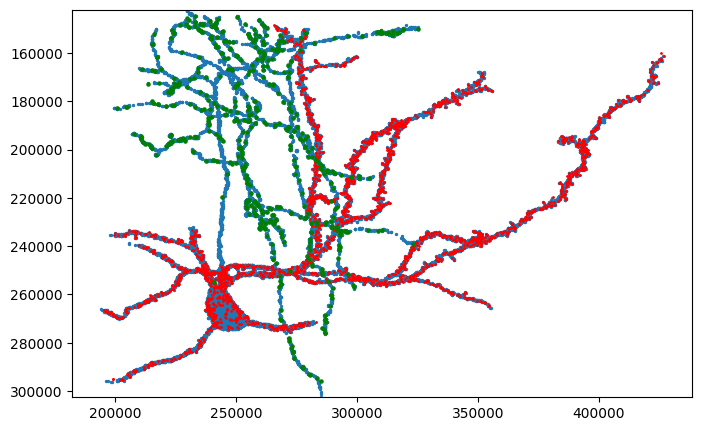

In [13]:
f,ax = plt.subplots(figsize=(8,8))
ax.scatter(mesh.vertices[::50,0], mesh.vertices[::50,1], s=2, alpha=1) # modify s and alpha to improve the visualization

ax.scatter(postsyn_xyz[:,0], postsyn_xyz[:,1], c='red', s=1, alpha=1) # modify c, s, and alpha if desired
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))

ax.scatter(presyn_xyz[:,0], presyn_xyz[:,1], c='green', s=5, alpha=1) # modify c, s, and alpha if desired
ax.set_aspect('equal')
ax.set_ylim(np.max(mesh.vertices[:,1]), np.min(mesh.vertices[:,1]))

In [14]:
len(postsyn_xyz)

2459

In [15]:
len(presyn_xyz)

516

In [16]:
# Make a list of the pre_root_ids that form a synapse on this cell
cell_post_subgraph

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
312642,1655204,648518346346296013,648518346349538179,253,317472,189744,83920,79390,47456,2098,79368,47436,2098,79306,47410,2098
584216,795137,648518346342804039,648518346349538179,133,333352,255752,26920,83350,63888,672,83338,63938,673,83320,63950,672
1752243,2232100,648518346341395461,648518346349538179,442,339336,244944,38360,84802,61242,959,84834,61236,959,84836,61202,959
1901911,2435053,648518346349538421,648518346349538179,593,359928,235136,33160,90012,58830,826,89982,58784,829,89942,58774,826
2197524,2800660,648518346349539097,648518346349538179,130,340148,245668,38640,85040,61398,969,85037,61417,966,84978,61410,968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3125651,235117,648518346349539517,648518346349538179,875,338004,235640,18640,84428,58842,467,84501,58910,466,84454,58920,467
3125652,2482972,648518346349539803,648518346349538179,643,283720,189976,38960,70916,47452,975,70930,47494,974,70882,47548,975
3126078,2203173,648518346349531742,648518346349538179,427,283864,190328,39000,70922,47650,975,70966,47582,975,70904,47548,975
3126085,2332022,648518346349536816,648518346349538179,506,393192,199072,16040,98272,49726,399,98298,49768,401,98312,49796,399


In [17]:
# Uncomment if you want to generate a list for copy and pasting
# cell_post_subgraph["pre_root_id"].to_list()

In [18]:
# Make a list of the post_root_ids that receive a synapse from this cell
cell_pre_subgraph

,id,pre_root_id,post_root_id,cleft_vx,ctr_pt_x_nm,ctr_pt_y_nm,ctr_pt_z_nm,pre_pos_x_vx,pre_pos_y_vx,pre_pos_z_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,post_pos_x_vx,post_pos_y_vx,post_pos_z_vx
144,2925203,648518346349538179,648518346349538290,122,245088,155188,66880,61252,38694,1668,61272,38797,1672,61208,38738,1669
281,2333890,648518346349538179,648518346342808283,508,264904,162496,73160,66200,40592,1830,66226,40624,1829,66172,40674,1830
287,2323843,648518346349538179,648518346346304831,500,278264,195776,72720,69558,49004,1821,69566,48944,1818,69474,49010,1821
544,2241420,648518346349538179,648518346341418659,448,280056,245336,65160,69996,61314,1626,70014,61334,1629,70034,61380,1625
592,1584603,648518346349538179,648518346349537921,240,237328,170112,56400,59286,42520,1408,59332,42528,1410,59378,42544,1408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054494,1709628,648518346349538179,648518346349524971,264,285424,250768,74520,71316,62710,1865,71356,62692,1863,71368,62656,1866
3054495,548781,648518346349538179,648518346349524971,227,290768,209804,79720,72642,52478,1995,72692,52451,1993,72680,52418,1995
3138335,2254090,648518346349538179,648518346349539836,455,238672,189624,80760,59608,47404,2015,59668,47406,2019,59702,47388,2015
3197227,3278965,648518346349538179,648518346349538312,174,264224,229556,66360,66016,57366,1661,66056,57389,1659,65994,57396,1659


In [19]:
# Uncomment if you will to generate a list for copy and pasting
# cell_pre_subgraph["post_root_id"].to_list()

In [20]:
# 3D visualizer using OpenGL and vtk tool
# You must have OpenGL installed on your computer

import vtk

In [21]:
# Use this visualization if you do NOT want to see the synaptic sites (cell mesh only)

#create vtk actors for each mesh and one for their shared synapses
mesh_actor = trimesh_vtk.mesh_actor(mesh, opacity=.3, color=(0.2, 0.4, 0.7)) #adjust color if desired

#creating a camera object and defining the view
camera = trimesh_vtk.oriented_camera(mesh.centroid, backoff=400)

#render the actors, will open a pop up python window
trimesh_vtk.render_actors([mesh_actor], camera=camera)

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer(0x0000027894528360) at 0x00000278A817CCA8>

In [22]:
# Use this visualization if you want to see the synaptic sites

#create vtk actors for each mesh and one for their shared synapses
mesh_actor = trimesh_vtk.mesh_actor(mesh, opacity=.3, color=(0.2, 0.4, 0.7)) #adjust color if desired
presyn_actor = trimesh_vtk.point_cloud_actor(presyn_xyz, size=500, color=(0.2, 0.9, 0.2)) #adjust size and color if desired 
postsyn_actor = trimesh_vtk.point_cloud_actor(postsyn_xyz, size=250, color=(0.9, 0.2, 0.2)) #adjust size and color if desired


#creating a camera object and defining the view
camera = trimesh_vtk.oriented_camera(mesh.centroid, backoff=400)

#render the actors, will open a pop up python window
trimesh_vtk.render_actors([mesh_actor,presyn_actor, postsyn_actor], camera=camera)

setting up renderer
done setting up
actors added
camera set
render done
finalizing..


<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer(0x00000278B2526AB0) at 0x00000278A817C468>